### Importing the Dependencies

In [ ]:
!pip install yfinance seaborn

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential


color_pal = sns.color_palette()
plt.style.use(style='seaborn')
%matplotlib inline

In [3]:
# Use yfinance to fetch historical market data for Microsoft
market_dataset = yf.download('GOOG', start='2012-01-01', end='2022-12-21')

# # loading the data from csv file to pandas dataframe
# market_dataset = pd.read_csv('Train.csv')

/opt/conda/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


### Data PreProcessing

In [4]:
market_dataset

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,16.262545,16.641375,16.248346,16.573130,16.573130,147611217
2012-01-04,16.563665,16.693678,16.453827,16.644611,16.644611,114989399
2012-01-05,16.491436,16.537264,16.344486,16.413727,16.413727,131808205
2012-01-06,16.417213,16.438385,16.184088,16.189817,16.189817,108119746
2012-01-09,16.102144,16.114599,15.472754,15.503389,15.503389,233776981
...,...,...,...,...,...,...
2022-12-14,95.540001,97.220001,93.940002,95.309998,95.309998,26452900
2022-12-15,93.540001,94.029999,90.430000,91.199997,91.199997,28298800
2022-12-16,91.199997,91.750000,90.010002,90.860001,90.860001,48485500


In [5]:
# statistical measures of the dataset
market_dataset.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2761.000000,2761.000000,2761.000000,2761.000000,2761.000000,2.761000e+03
mean,55.307854,55.867984,54.756463,55.320194,55.320194,4.554107e+07
std,35.776071,36.195672,35.366847,35.775091,35.775091,3.604813e+07
min,13.956189,14.060299,13.861045,13.924059,13.924059,1.584340e+05
25%,27.424706,27.659561,27.128019,27.427942,27.427942,2.503800e+07
50%,46.452999,46.672001,46.151501,46.439999,46.439999,3.294800e+07
75%,69.156502,69.938004,67.763496,69.418503,69.418503,5.339539e+07
max,151.863495,152.100006,149.887497,150.709000,150.709000,4.995615e+08


In [6]:
# market_dataset.set_index('Date', inplace=True)
market_dataset.reset_index(inplace=True)
market_dataset["Date"]=pd.to_datetime(market_dataset.Date)

In [7]:
market_dataset.shape

(2761, 7)

In [8]:
market_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2761 entries, 0 to 2760
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2761 non-null   datetime64[ns]
 1   Open       2761 non-null   float64       
 2   High       2761 non-null   float64       
 3   Low        2761 non-null   float64       
 4   Close      2761 non-null   float64       
 5   Adj Close  2761 non-null   float64       
 6   Volume     2761 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 151.1 KB


In [9]:
# check for missing values
market_dataset.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [10]:
# # Drop rows with few missing values
market_dataset = market_dataset.dropna()

In [11]:
#Understanding the correlation between various features in the dataset
correlation = market_dataset.corr()

<Axes: >

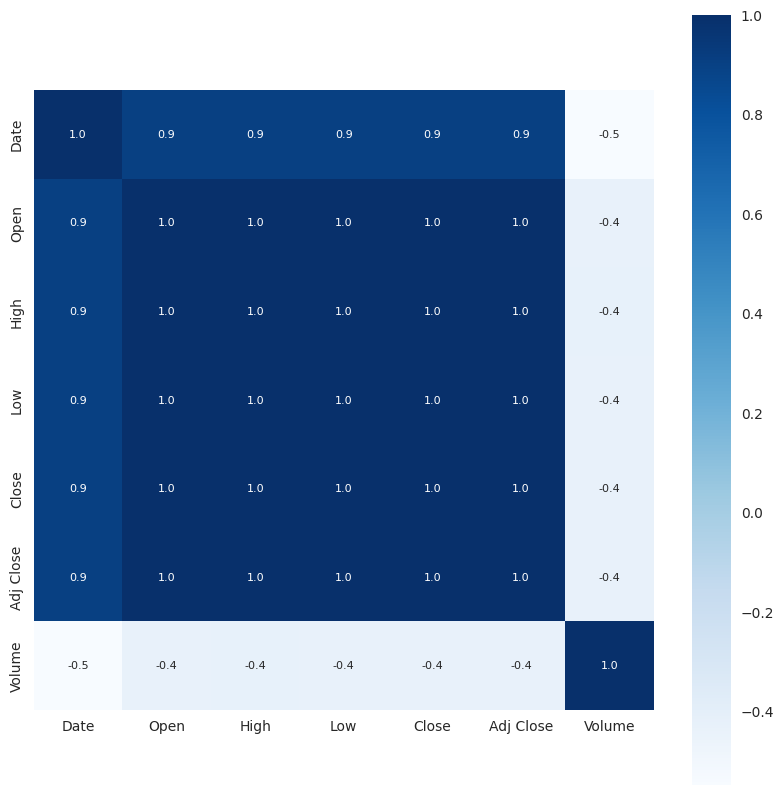

In [12]:
# constructing a heatmap to nderstand the correlation
plt.figure(figsize=(10,10))
sns.heatmap(correlation, cbar=True, square=True, fmt='.1f', annot=True, annot_kws={'size':8}, cmap='Blues')

In [13]:
print(correlation['Close'])

Date         0.906476
Open         0.999643
High         0.999826
Low          0.999843
Close        1.000000
Adj Close    1.000000
Volume      -0.429483
Name: Close, dtype: float64


### spliting data and target & training and test

In [16]:
data_train = pd.DataFrame(market_dataset.Close[0: int(len(market_dataset)*0.80)])
data_test = pd.DataFrame(market_dataset.Close[int(len(market_dataset)*0.80): len(market_dataset)])

pas_100_days = data_train.tail(100)
data_test_ = pd.concat([pas_100_days, data_test], ignore_index=True)

scaler = MinMaxScaler(feature_range=(0,1))
data_train_scale = scaler.fit_transform(data_train)
data_test_scale  =  scaler.fit_transform(data_test_)

In [17]:
print(market_dataset.Close.shape, data_train.shape, data_test.shape)

(2761,) (2208, 1) (553, 1)


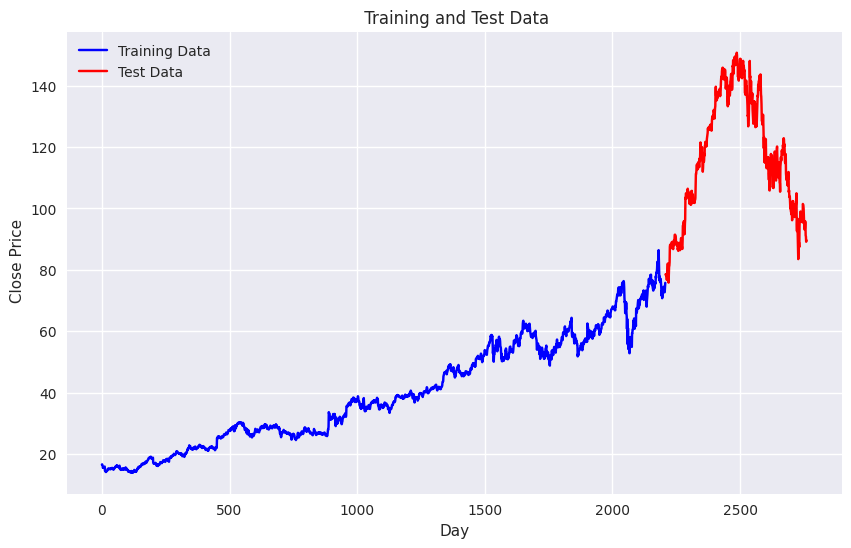

In [18]:
# Plot training data
plt.figure(figsize=(10, 6))
plt.plot(data_train.index, data_train, label='Training Data', color='blue')

# Plot test data
plt.plot(data_test.index, data_test, label='Test Data', color='red')

plt.title(' Training and Test Data')
plt.xlabel('Day')
plt.ylabel(' Close Price')
plt.legend()
plt.show()

In [19]:
#for training data
x = []
y = []

for i in range(100, data_train_scale.shape[0]):
    x.append(data_train_scale[i-100:i])
    y.append(data_train_scale[i,0])
x, y = np.array(x), np.array(y)
x.shape, y.shape

((2108, 100, 1), (2108,))

In [20]:
#for test data
x2 = []
y2 = []

for i in range(100, data_test_scale.shape[0]):
    x2.append(data_test_scale[i-100:i])
    y2.append(data_test_scale[i,0])
x2, y2 = np.array(x2), np.array(y2)
x2.shape, y2.shape

((553, 100, 1), (553,))

### Model training

In [21]:
model = Sequential()
model.add(LSTM(units = 50, activation = 'relu', return_sequences = True,
               input_shape = ((x.shape[1],1))))
model.add(Dropout(0.2))

model.add(LSTM(units = 60, activation='relu', return_sequences = True))
model.add(Dropout(0.3))

model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
model.add(Dropout(0.4))

model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(units =1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.fit(x,y, epochs = 50, batch_size =32, verbose =1)

Epoch 1/50
66/66 [==============================] - 17s 186ms/step - loss: 0.0345
Epoch 2/50
66/66 [==============================] - 13s 190ms/step - loss: 0.0077
Epoch 3/50
66/66 [==============================] - 12s 186ms/step - loss: 0.0070
Epoch 4/50
66/66 [==============================] - 12s 185ms/step - loss: 0.0057
Epoch 5/50
66/66 [==============================] - 13s 190ms/step - loss: 0.0049
Epoch 6/50
66/66 [==============================] - 12s 186ms/step - loss: 0.0053
Epoch 7/50
66/66 [==============================] - 13s 190ms/step - loss: 0.0046
Epoch 8/50
66/66 [==============================] - 12s 187ms/step - loss: 0.0049
Epoch 9/50
66/66 [==============================] - 12s 188ms/step - loss: 0.0042
Epoch 10/50
66/66 [==============================] - 13s 190ms/step - loss: 0.0040
Epoch 11/50
66/66 [==============================] - 12s 186ms/step - loss: 0.0039
Epoch 12/50
66/66 [==============================] - 13s 190ms/step - loss: 0.0041
Epoch 13/50
6

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 60)           26640     
                                                                 
 dropout_1 (Dropout)         (None, 100, 60)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 80)           45120     
                                                                 
 dropout_2 (Dropout)         (None, 100, 80)           0         
                                                                 
 lstm_3 (LSTM)               (None, 120)               9

### Model Evaluation

In [23]:
y_predict = model.predict(x2)
scale =1/scaler.scale_
y_predict = y_predict*scale
y2 = y2*scale

18/18 [==============================] - 2s 64ms/step


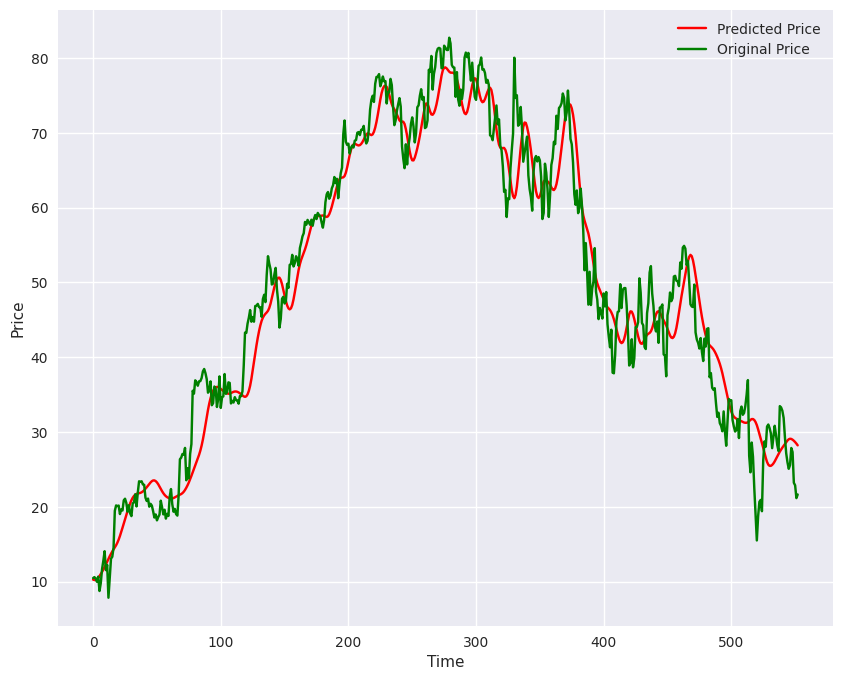

In [24]:
plt.figure(figsize=(10,8))
plt.plot(y_predict, 'r', label = 'Predicted Price')
plt.plot(y2, 'g', label = 'Original Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [25]:
model.save('Stock_Predictions_Model.keras')

### Building a Predictive System

In [ ]:
import numpy as np

input_data_scaled = scaler.transform(np.array(input_data).reshape(-1, 1))
input_data_scaled_reshaped = input_data_scaled.reshape(1, 100, 1)  # Reshape for LSTM input shape

# Make prediction
prediction = model.predict(input_data_scaled_reshaped)

# nverse transform to get the actual prices
prediction_actual = prediction * scale  

print("Price:", prediction_actual[0])